## 1. 导入必要库，选择场类型

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio.v2 as imageio
from omegaconf import OmegaConf
import os
import sys
from typing import Optional, Tuple, List, Dict, Any, Union
from pathlib import Path
from funcmol.utils.constants import PADDING_INDEX
from funcmol.utils.utils_nf import create_neural_field, load_neural_field
from funcmol.utils.gnf_converter import GNFConverter
from lightning import Fabric
from torch_geometric.utils import to_dense_batch
from funcmol.dataset.dataset_field import create_field_loaders
import hydra

project_root = Path(os.getcwd()).parent
sys.path.insert(0, str(project_root))

import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [21]:
# 1表示使用标准答案gt，2表示使用预测场predicted
FIELD_OPTION = 2

## 2. 分子重建指标计算

In [22]:
class MoleculeMetrics:
    """分子重建指标计算类"""
    
    @staticmethod
    def compute_rmsd(coords1: torch.Tensor, coords2: torch.Tensor) -> torch.Tensor:
        """计算两个坐标集之间的对称RMSD - 优化版本，保持梯度"""
        coords1 = coords1.detach().requires_grad_(True)
        coords2 = coords2.detach().requires_grad_(True)
        
        dist1 = torch.sqrt(torch.sum((coords1.unsqueeze(1) - coords2.unsqueeze(0))**2, dim=2) + 1e-8)
        dist2 = torch.sqrt(torch.sum((coords2.unsqueeze(1) - coords1.unsqueeze(0))**2, dim=2) + 1e-8)
        
        min_dist1 = torch.min(dist1, dim=1)[0]
        min_dist2 = torch.min(dist2, dim=1)[0]
        
        rmsd = (torch.mean(min_dist1) + torch.mean(min_dist2)) / 2
        
        return rmsd
    
    @staticmethod
    def compute_rmsd_scalar(coords1: torch.Tensor, coords2: torch.Tensor) -> float:
        """计算两个坐标集之间的对称RMSD - 返回标量版本（用于评估）"""
        rmsd = MoleculeMetrics.compute_rmsd(coords1, coords2)
        return rmsd.item()
    
    @staticmethod
    def compute_reconstruction_loss(coords: torch.Tensor, points: torch.Tensor) -> torch.Tensor:
        """计算重建损失 - 优化版本，保持梯度"""
        dist1 = torch.sum((coords.unsqueeze(1) - points.unsqueeze(0))**2, dim=2)
        
        eps = 1e-8
        
        min_dist_to_samples = torch.min(dist1 + eps, dim=1)[0]
        min_dist_to_atoms = torch.min(dist1 + eps, dim=0)[0]
        
        coverage_loss = torch.mean(min_dist_to_samples)
        clustering_loss = torch.mean(min_dist_to_atoms)
        
        total_loss = coverage_loss + 0.1 * clustering_loss
        
        return torch.sqrt(total_loss)
    
    @staticmethod
    def compute_reconstruction_loss_scalar(coords: torch.Tensor, points: torch.Tensor) -> float:
        """计算重建损失 - 返回标量版本（用于评估）"""
        loss = MoleculeMetrics.compute_reconstruction_loss(coords, points)
        return loss.item()
    
    @staticmethod
    def compute_kl_divergences(coords1: torch.Tensor, coords2: torch.Tensor, temperature: float = 0.1) -> Tuple[torch.Tensor, torch.Tensor]:
        """计算两个坐标集之间的双向KL散度 - 优化版本，保持梯度"""
        dist_matrix = torch.sum((coords1.unsqueeze(1) - coords2.unsqueeze(0))**2, dim=2)
        
        p1_given_2 = torch.softmax(-dist_matrix / temperature, dim=0)
        p2_given_1 = torch.softmax(-dist_matrix / temperature, dim=1)
        
        eps = 1e-8
        
        kl_1to2 = torch.mean(torch.sum(p1_given_2 * torch.log(p1_given_2 / (1.0/coords2.shape[0] + eps) + eps), dim=0))
        kl_2to1 = torch.mean(torch.sum(p2_given_1 * torch.log(p2_given_1 / (1.0/coords1.shape[0] + eps) + eps), dim=1))
        
        return kl_1to2, kl_2to1
    
    @staticmethod
    def compute_kl_divergences_scalar(coords1: torch.Tensor, coords2: torch.Tensor, temperature: float = 0.1) -> Tuple[float, float]:
        """计算两个坐标集之间的双向KL散度 - 返回标量版本（用于评估）"""
        kl_1to2, kl_2to1 = MoleculeMetrics.compute_kl_divergences(coords1, coords2, temperature)
        return kl_1to2.item(), kl_2to1.item()


## 3. 分子结构可视化

In [23]:
class MoleculeVisualizer:
    """分子结构可视化基类"""
    
    def __init__(self):
        self.atom_colors = {
            0: 'black',   # C
            1: 'gray',    # H
            2: 'red',     # O
            3: 'blue',    # N
            4: 'green',   # F
        }
        
        plt.style.use('default')
        plt.rcParams['figure.dpi'] = 150
        plt.rcParams['savefig.dpi'] = 300
    
    def _get_atom_colors(self, atom_types: torch.Tensor) -> List[str]:
        """根据原子类型获取颜色列表"""
        return [self.atom_colors.get(int(atom_type), 'gray') for atom_type in atom_types]
    
    def _setup_3d_axis(self, ax: plt.Axes, coords_list: List[np.ndarray], margin: float = 0.5):
        """设置3D坐标轴的共同属性"""
        ax.set_xlabel('X (Å)')
        ax.set_ylabel('Y (Å)')
        ax.set_zlabel('Z (Å)')
        ax.grid(True, alpha=0.3)
        
        all_coords = np.vstack(coords_list)
        x_min, x_max = all_coords[:, 0].min() - margin, all_coords[:, 0].max() + margin
        y_min, y_max = all_coords[:, 1].min() - margin, all_coords[:, 1].max() + margin
        z_min, z_max = all_coords[:, 2].min() - margin, all_coords[:, 2].max() + margin
        
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_zlim(z_min, z_max)


## 4. GNF重建过程相关函数

In [24]:
class GNFVisualizer(MoleculeVisualizer):
    """GNF重建过程可视化类"""
    
    def __init__(self, output_dir: str = "gnf_reconstruction_results"):
        super().__init__()
        self.output_dir = output_dir
        self.metrics = MoleculeMetrics()
        os.makedirs(output_dir, exist_ok=True)
    
    def visualize_molecule_comparison(self, 
                                    orig_coords: torch.Tensor, 
                                    recon_coords: torch.Tensor,
                                    orig_types: Optional[torch.Tensor] = None,
                                    recon_types: Optional[torch.Tensor] = None,
                                    save_path: Optional[str] = None,
                                    title: str = "Molecule Comparison"):
        """可视化原始分子和重建分子的对比 - 优化版本"""
        fig = plt.figure(figsize=(15, 7))
        
        ax1 = fig.add_subplot(131, projection='3d')
        orig_coords_np = orig_coords.detach().cpu().numpy()
        
        if orig_types is not None:
            orig_types_np = orig_types.detach().cpu().numpy()
            for atom_type in range(5):
                mask = (orig_types_np == atom_type)
                if mask.sum() > 0:
                    ax1.scatter(orig_coords_np[mask, 0], orig_coords_np[mask, 1], orig_coords_np[mask, 2], 
                               c=self.atom_colors[atom_type], marker='o', s=100, 
                               label=f'Original {["C", "H", "O", "N", "F"][atom_type]}')
        else:
            ax1.scatter(orig_coords_np[:, 0], orig_coords_np[:, 1], orig_coords_np[:, 2], 
                       c='blue', marker='o', s=100, label='Original', alpha=0.8)
        ax1.set_title("Original Molecule")
        ax1.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
        
        ax2 = fig.add_subplot(132, projection='3d')
        recon_coords_np = recon_coords.detach().cpu().numpy()
        
        if recon_types is not None:
            recon_types_np = recon_types.detach().cpu().numpy()
            for atom_type in range(5):
                mask = (recon_types_np == atom_type)
                if mask.sum() > 0:
                    ax2.scatter(recon_coords_np[mask, 0], recon_coords_np[mask, 1], recon_coords_np[mask, 2], 
                               c=self.atom_colors[atom_type], marker='o', s=100, 
                               label=f'Reconstructed {["C", "H", "O", "N", "F"][atom_type]}')
        else:
            ax2.scatter(recon_coords_np[:, 0], recon_coords_np[:, 1], recon_coords_np[:, 2], 
                       c='red', marker='o', s=100, label='Reconstructed', alpha=0.8)
        ax2.set_title("Reconstructed Molecule")
        ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
        
        ax3 = fig.add_subplot(133, projection='3d')
        
        if orig_types is not None:
            for atom_type in range(5):
                mask = (orig_types_np == atom_type)
                if mask.sum() > 0:
                    ax3.scatter(orig_coords_np[mask, 0], orig_coords_np[mask, 1], orig_coords_np[mask, 2], 
                               c=self.atom_colors[atom_type], marker='o', s=100, alpha=0.5, 
                               label=f'Original {["C", "H", "O", "N", "F"][atom_type]}')
        
        if recon_types is not None:
            for atom_type in range(5):
                mask = (recon_types_np == atom_type)
                if mask.sum() > 0:
                    ax3.scatter(recon_coords_np[mask, 0], recon_coords_np[mask, 1], recon_coords_np[mask, 2], 
                               c=self.atom_colors[atom_type], marker='s', s=100, alpha=0.5, 
                               label=f'Reconstructed {["C", "H", "O", "N", "F"][atom_type]}')
        else:
            ax3.scatter(recon_coords_np[:, 0], recon_coords_np[:, 1], recon_coords_np[:, 2], 
                       c='red', marker='s', s=100, alpha=0.5, label='Reconstructed')
        ax3.set_title("Comparison")
        ax3.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
        
        for ax in [ax1, ax2, ax3]:
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.grid(True)
            ax.set_xlim([-1, 1])
            ax.set_ylim([-1, 1])
            ax.set_zlim([-1, 1])
        
        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()
        
        return fig

    def visualize_reconstruction_step(self, 
                                    coords: torch.Tensor,
                                    current_points: torch.Tensor,
                                    iteration: int,
                                    save_path: str,
                                    coords_types: Optional[torch.Tensor] = None,
                                    points_types: Optional[torch.Tensor] = None):
        """可视化重建过程的单个步骤 - 优化版本"""
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        coords_np = coords.detach().cpu().numpy()
        if coords_types is not None:
            coords_types_np = coords_types.detach().cpu().numpy()
            for atom_type in range(5):
                mask = (coords_types_np == atom_type)
                if mask.sum() > 0:
                    ax.scatter(coords_np[mask, 0], coords_np[mask, 1], coords_np[mask, 2], 
                              c=self.atom_colors[atom_type], marker='o', s=100, 
                              label=f'Original {["C", "H", "O", "N", "F"][atom_type]}', alpha=0.7)
        else:
            ax.scatter(coords_np[:, 0], coords_np[:, 1], coords_np[:, 2], 
                      c='blue', marker='o', s=100, label='Original', alpha=0.8)
        
        points_np = current_points.detach().cpu().numpy()
        if points_types is not None:
            points_types_np = points_types.detach().cpu().numpy()
            for atom_type in range(5):
                mask = (points_types_np == atom_type)
                if mask.sum() > 0:
                    ax.scatter(points_np[mask, 0], points_np[mask, 1], points_np[mask, 2],
                              c=self.atom_colors[atom_type], marker='.', s=10, 
                              label=f'Current {["C", "H", "O", "N", "F"][atom_type]}', alpha=0.3)
        else:
            ax.scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2], 
                      c='red', marker='.', s=5, label='Current Points', alpha=0.4)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.grid(True)
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_title(f"Iteration {iteration}")
        ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
        
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    
    def create_reconstruction_animation(self,
                                    gt_coords: torch.Tensor,
                                    gt_types: torch.Tensor,
                                    converter: GNFConverter,
                                    decoder: torch.nn.Module,
                                    codes: torch.Tensor,
                                    save_interval: int = 50,
                                    animation_name: str = "reconstruction",
                                    field_option: int = 1,
                                    sample_idx: int = 1) -> Dict[str, Any]:
        """创建重建过程动画"""
        device = gt_coords.device
        
        gt_mask = (gt_types[sample_idx] != PADDING_INDEX)
        gt_valid_coords = gt_coords[sample_idx][gt_mask]
        gt_valid_types = gt_types[sample_idx][gt_mask]
        
        print(f"\nStarting reconstruction for molecule {sample_idx}")
        print(f"Ground truth atoms: {len(gt_valid_coords)}")
        print(f"Atom types: {gt_valid_types.tolist()}")
        
        all_atom_types = list(range(5))
        
        z_dict = {}
        for atom_type in all_atom_types:
            z_dict[atom_type] = torch.rand(converter.n_query_points, 3, device=device) * 2 - 1
        
        def gnf_func(points):
            """一次性计算所有原子类型的梯度场"""
            if field_option == 1:
                vector_field = converter.mol2gnf(
                    gt_valid_coords.unsqueeze(0),
                    gt_valid_types.unsqueeze(0),
                    points.unsqueeze(0)
                )
                return vector_field[0]
            else:
                field = decoder(points.unsqueeze(0), codes[sample_idx:sample_idx+1])[0]
                return field
        
        frame_paths = []
        metrics_history = {
            'iterations': [],
            'loss': [],
            'rmsd': [],
            'kl_1to2': [],
            'kl_2to1': []
        }
        
        for i in range(converter.n_iter):
            with torch.no_grad():
                for atom_type in all_atom_types:
                    z = z_dict[atom_type]
                    
                    gradients = gnf_func(z)
                    type_gradients = gradients[:, atom_type, :]
                    
                    if i % 1000 == 0:
                        grad_norm = torch.norm(type_gradients, dim=1).mean().item()
                        print(f"Iteration {i}, Atom type {atom_type}: grad norm = {grad_norm:.6f}")
                    
                    z_dict[atom_type] = z + converter.step_size * type_gradients
            
            if i % save_interval == 0 or i == converter.n_iter - 1:
                frame_path = os.path.join(self.output_dir, f"frame_{i:04d}.png")
                
                all_points = []
                all_types = []
                for atom_type in all_atom_types:
                    points = z_dict[atom_type]
                    if len(points) > 0:
                        all_points.append(points)
                        all_types.extend([atom_type] * len(points))
                    
                if all_points:
                    current_points = torch.cat(all_points, dim=0)
                    current_types = torch.tensor(all_types, device=device)
                else:
                    current_points = torch.empty((0, 3), device=device)
                    current_types = torch.empty((0,), device=device)
                
                self.visualize_reconstruction_step(
                    gt_valid_coords, current_points, i, frame_path, 
                    gt_valid_types, current_types
                )
                frame_paths.append(frame_path)
                
                if len(current_points) > 0:
                    metrics_history['iterations'].append(i)
                    metrics_history['loss'].append(
                        self.metrics.compute_reconstruction_loss_scalar(gt_valid_coords, current_points)
                    )
                    metrics_history['rmsd'].append(
                        self.metrics.compute_rmsd_scalar(gt_valid_coords, current_points)
                    )
                    kl_1to2, kl_2to1 = self.metrics.compute_kl_divergences_scalar(
                        gt_valid_coords, current_points
                    )
                    metrics_history['kl_1to2'].append(kl_1to2)
                    metrics_history['kl_2to1'].append(kl_2to1)
        
        gif_path = os.path.join(self.output_dir, f"{animation_name}.gif")
        with imageio.get_writer(gif_path, mode='I', duration=0.3) as writer:
            for frame_path in frame_paths:
                writer.append_data(imageio.imread(frame_path))
                os.remove(frame_path)
        
        final_points = []
        final_types = []
        for atom_type in all_atom_types:
            points = z_dict[atom_type].detach().cpu().numpy()
            if len(points) > 0:
                merged_points = converter._merge_points(points)
                if len(merged_points) > 0:
                    final_points.append(torch.from_numpy(merged_points).to(device))
                    final_types.extend([atom_type] * len(merged_points))
        
        if final_points:
            final_points = torch.cat(final_points, dim=0)
            final_types = torch.tensor(final_types, device=device)
        else:
            final_points = torch.empty((0, 3), device=device)
            final_types = torch.empty((0,), device=device)
        
        comparison_path = os.path.join(self.output_dir, f"{animation_name}_final.png")
        self.visualize_molecule_comparison(
            gt_valid_coords,
            final_points,
            gt_valid_types,
            final_types,
            save_path=comparison_path
        )
        
        return {
            'gif_path': gif_path,
            'comparison_path': comparison_path,
            'metrics_history': metrics_history,
            'final_points': final_points,
            'final_types': final_types,
            'final_rmsd': metrics_history['rmsd'][-1] if metrics_history['rmsd'] else float('inf'),
            'final_loss': metrics_history['loss'][-1] if metrics_history['loss'] else float('inf'),
            'final_kl_1to2': metrics_history['kl_1to2'][-1] if metrics_history['kl_1to2'] else float('inf'),
            'final_kl_2to1': metrics_history['kl_2to1'][-1] if metrics_history['kl_2to1'] else float('inf')
        }

def visualize_reconstruction(gt_coords: torch.Tensor,
                           gt_types: torch.Tensor,
                           converter: GNFConverter,
                           decoder: torch.nn.Module,
                           codes: torch.Tensor,
                           output_dir: str = "reconstruction_results",
                           sample_idx: int = 0) -> Dict[str, Any]:
    """便捷函数：可视化分子重建过程"""
    visualizer = GNFVisualizer(output_dir)
    return visualizer.create_reconstruction_animation(
        gt_coords, gt_types, converter, decoder, codes,
        sample_idx=sample_idx
    )

## 执行GNF可视化

In [25]:
def setup_environment():
    """初始化运行环境"""
    print("GNF Visualizer for QM9 Dataset")
    
    fabric = Fabric(
        accelerator="auto",
        devices=1,
        precision="32-true",
        strategy="auto"
    )
    fabric.launch()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    return fabric, device

def load_config():
    """加载配置文件"""
    config_path = Path(os.getcwd()).parent / "configs" / "train_nf_qm9.yaml"
    if not config_path.exists():
        raise FileNotFoundError(f"Config file not found: {config_path}")
    
    with hydra.initialize_config_dir(config_dir=str(config_path.parent), version_base=None):
        config = hydra.compose(config_name="train_nf_qm9")
    
    config["dset"]["data_dir"] = str(project_root / "dataset" / "data")
    print(f"Dataset directory: {config['dset']['data_dir']}")
    
    return config

def load_model(fabric, config):
    """加载预训练模型"""
    exp_dir = Path(os.getcwd()).parent / "exps" / "neural_field"
    if not exp_dir.exists():
        raise FileNotFoundError(f"Experiment directory not found: {exp_dir}")
    
    exp_dirs = [d for d in exp_dir.iterdir() if d.is_dir() and d.name.startswith("nf_qm9_")]
    if not exp_dirs:
        raise FileNotFoundError("No experiment directories found")
    
    latest_exp_dir = max(exp_dirs, key=lambda x: x.stat().st_mtime)
    model_path = latest_exp_dir / "model.pt"
    
    if not model_path.exists():
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    print(f"Loading model from: {model_path}")
    
    enc, dec = create_neural_field(config, fabric)
    
    if hasattr(enc, '_orig_mod'):
        enc = enc._orig_mod
    if hasattr(dec, '_orig_mod'):
        dec = dec._orig_mod
    
    checkpoint = fabric.load(str(model_path))
    enc = load_neural_field(checkpoint, fabric, config)[0]
    dec = load_neural_field(checkpoint, fabric, config)[1]
    print("Model loaded successfully!")
    
    return enc, dec

def create_converter(config, device):
    """创建GNF转换器"""
    gnf_config = config.get("converter", {}) or config.get("gnf_converter", {})
    sigma_ratios = gnf_config.get("sigma_ratios", None)
    if sigma_ratios is not None and not isinstance(sigma_ratios, dict):
        sigma_ratios = OmegaConf.to_container(sigma_ratios, resolve=True)
    
    return GNFConverter(
        sigma=gnf_config.get("sigma", 1),
        n_query_points=gnf_config.get("n_query_points", 1000),
        n_iter=gnf_config.get("n_iter", 2000),
        step_size=gnf_config.get("step_size", 0.002),
        eps=gnf_config.get("eps", 0.1),
        min_samples=gnf_config.get("min_samples", 5),
        device=device,
        sigma_ratios=sigma_ratios,
        version=gnf_config.get("version", 2),
        temperature=gnf_config.get("temperature", 0.008)
    )

def prepare_data(fabric, config, device):
    """准备数据"""
    loader_val = create_field_loaders(config, split="val", fabric=fabric)
    
    batch = next(iter(loader_val)).to(device)
    
    coords, _ = to_dense_batch(batch.pos, batch.batch, fill_value=0)
    atoms_channel, _ = to_dense_batch(batch.x, batch.batch, fill_value=PADDING_INDEX)
    
    return batch, coords, atoms_channel

def run_visualization(visualizer, gt_coords, gt_types, converter, decoder, codes, sample_idx: int):
    """执行可视化"""
    try:
        results = visualizer.create_reconstruction_animation(
            gt_coords=gt_coords,
            gt_types=gt_types,
            converter=converter,
            decoder=decoder,
            codes=codes,
            save_interval=100,
            animation_name="recon",
            field_option=FIELD_OPTION,
            sample_idx=sample_idx
        )
        
        print("\n=== 重建结果 ===")
        print(f"RMSD: {results['final_rmsd']:.4f}")
        print(f"Reconstruction Loss: {results['final_loss']:.4f}")
        print(f"KL Divergence (orig->recon): {results['final_kl_1to2']:.4f}")
        print(f"KL Divergence (recon->orig): {results['final_kl_2to1']:.4f}")
        
        print("\n输出文件:")
        print(f"  GIF动画: {results['gif_path']}")
        print(f"  对比图: {results['comparison_path']}")
        
        return results
        
    except Exception as e:
        print(f"Error during visualization: {e}")
        import traceback
        traceback.print_exc()
        return None

fabric, device = setup_environment()
config = load_config()
encoder, decoder = load_model(fabric, config)
converter = create_converter(config, device)
batch, gt_coords, gt_types = prepare_data(fabric, config, device)

print("Generating codes...")
with torch.no_grad():
    codes = encoder(batch)
    
print("Starting visualization...")

sample_idx = int(os.environ.get("SAMPLE_IDX", "0"))
print(f"Visualizing molecule sample {sample_idx}")
    
output_dir = f"gnf_visualization_results_sample_{sample_idx}"
visualizer = GNFVisualizer(output_dir)
    
results = run_visualization(visualizer, gt_coords, gt_types, converter, decoder, codes, sample_idx=sample_idx)
if results is not None:
    print("GNF visualization completed successfully!")

GNF Visualizer for QM9 Dataset
Using device: cuda
Dataset directory: /home/huayuchen/funcmol-main-neuralfield/funcmol/dataset/data
Loading model from: /home/huayuchen/funcmol-main-neuralfield/funcmol/exps/neural_field/nf_qm9_20250725_011601_974762/model.pt
>> loaded dec
>> loaded enc
>> loaded dec
>> loaded enc
Model loaded successfully!
>> val set size: 20042
Generating codes...
Starting visualization...
Visualizing molecule sample 0

Starting reconstruction for molecule 0
Ground truth atoms: 4
Atom types: [0, 2, 1, 1]
Iteration 0, Atom type 0: grad norm = 0.829234
Iteration 0, Atom type 1: grad norm = 0.751202
Iteration 0, Atom type 2: grad norm = 0.708310
Iteration 0, Atom type 3: grad norm = 0.512600
Iteration 0, Atom type 4: grad norm = 0.008919
Iteration 1000, Atom type 0: grad norm = 0.110889
Iteration 1000, Atom type 1: grad norm = 0.105526
Iteration 1000, Atom type 2: grad norm = 0.112943
Iteration 1000, Atom type 3: grad norm = 0.115464
Iteration 1000, Atom type 4: grad norm 

## 可视化一维梯度场

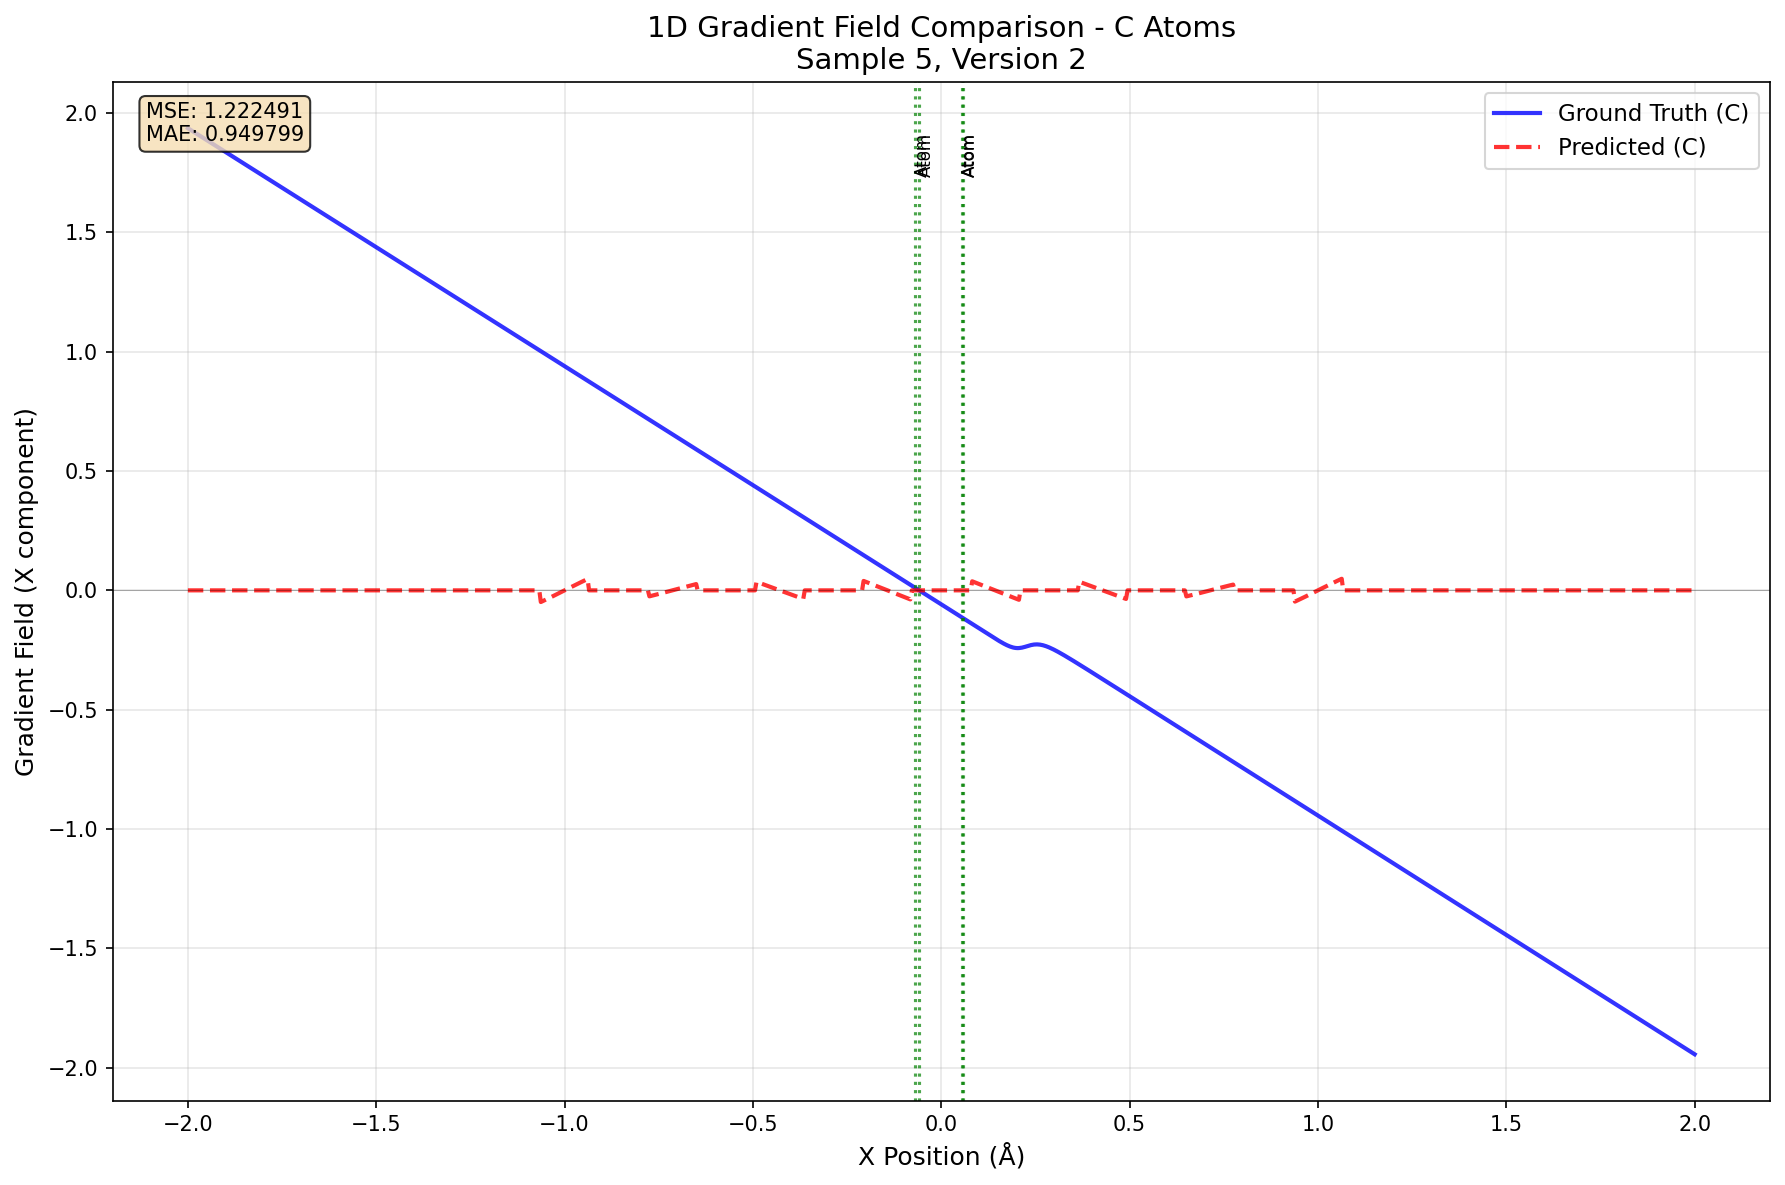


=== 梯度场对比统计 ===
原子类型: C
样本索引: 5
真实原子数量: 14
目标原子数量: 4
MSE: 1.222491
MAE: 0.949799
梯度场范围 - 真实: [-1.9434, 1.9359]
梯度场范围 - 预测: [-0.0489, 0.0486]


In [30]:
def visualize_1d_gradient_field_comparison(
    gt_coords: torch.Tensor,
    gt_types: torch.Tensor,
    converter: GNFConverter,
    decoder: torch.nn.Module,
    codes: torch.Tensor,
    sample_idx: int = 0,
    atom_type: int = 0,  # 0=C, 1=H, 2=O, 3=N, 4=F
    x_range: tuple = (-10, 10),
    n_points: int = 1000
):
    """
    可视化一维方向上的梯度场对比
    
    Args:
        gt_coords: 真实分子坐标 [batch, n_atoms, 3]
        gt_types: 真实原子类型 [batch, n_atoms]
        converter: GNF转换器
        decoder: 解码器模型
        codes: 编码器输出的codes [batch, code_dim]
        sample_idx: 要可视化的样本索引
        atom_type: 要可视化的原子类型 (0=C, 1=H, 2=O, 3=N, 4=F)
        x_range: x轴范围
        n_points: 采样点数
    """
    device = gt_coords.device
    
    # 获取当前样本的有效原子
    gt_mask = (gt_types[sample_idx] != PADDING_INDEX)
    gt_valid_coords = gt_coords[sample_idx][gt_mask]
    gt_valid_types = gt_types[sample_idx][gt_mask]
    
    # 创建一维采样点 (沿x轴)
    x = torch.linspace(x_range[0], x_range[1], n_points, device=device)
    query_points = torch.zeros(n_points, 3, device=device)
    query_points[:, 0] = x  # 只在x轴方向变化
    
    # 计算标准答案梯度场 (version 2)
    with torch.no_grad():
        gt_field = converter.mol2gnf(
            gt_valid_coords.unsqueeze(0),
            gt_valid_types.unsqueeze(0),
            query_points.unsqueeze(0)
        )
        gt_gradients = gt_field[0, :, atom_type, 0]  # 取x方向分量
    
    # 计算预测梯度场
    with torch.no_grad():
        pred_field = decoder(query_points.unsqueeze(0), codes[sample_idx:sample_idx+1])
        pred_gradients = pred_field[0, :, atom_type, 0]  # 取x方向分量
    
    # 创建可视化
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # 绘制梯度场
    ax.plot(x.cpu().numpy(), gt_gradients.cpu().numpy(), 
            label=f'Ground Truth ({["C", "H", "O", "N", "F"][atom_type]})', 
            linewidth=2, color='blue', alpha=0.8)
    ax.plot(x.cpu().numpy(), pred_gradients.cpu().numpy(), 
            label=f'Predicted ({["C", "H", "O", "N", "F"][atom_type]})', 
            linewidth=2, color='red', alpha=0.8, linestyle='--')
    
    # 标记原子位置
    atom_positions = gt_valid_coords[gt_valid_types == atom_type, 0].cpu().numpy()
    if len(atom_positions) > 0:
        for pos in atom_positions:
            ax.axvline(x=pos, color='green', linestyle=':', alpha=0.7, linewidth=1.5)
            ax.text(pos, ax.get_ylim()[1] * 0.9, f'Atom', 
                   rotation=90, verticalalignment='top', fontsize=8)
    
    # 添加零线
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
    
    # 设置图表属性
    ax.set_xlabel('X Position (Å)', fontsize=12)
    ax.set_ylabel('Gradient Field (X component)', fontsize=12)
    ax.set_title(f'1D Gradient Field Comparison - {["C", "H", "O", "N", "F"][atom_type]} Atoms\n'
                f'Sample {sample_idx}, Version 2', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    
    # 计算并显示误差
    mse = torch.mean((gt_gradients - pred_gradients) ** 2).item()
    mae = torch.mean(torch.abs(gt_gradients - pred_gradients)).item()
    
    ax.text(0.02, 0.98, f'MSE: {mse:.6f}\nMAE: {mae:.6f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"\n=== 梯度场对比统计 ===")
    print(f"原子类型: {['C', 'H', 'O', 'N', 'F'][atom_type]}")
    print(f"样本索引: {sample_idx}")
    print(f"真实原子数量: {len(gt_valid_coords)}")
    print(f"目标原子数量: {(gt_valid_types == atom_type).sum().item()}")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"梯度场范围 - 真实: [{gt_gradients.min().item():.4f}, {gt_gradients.max().item():.4f}]")
    print(f"梯度场范围 - 预测: [{pred_gradients.min().item():.4f}, {pred_gradients.max().item():.4f}]")
    
    return {
        'x': x.cpu().numpy(),
        'gt_gradients': gt_gradients.cpu().numpy(),
        'pred_gradients': pred_gradients.cpu().numpy(),
        'mse': mse,
        'mae': mae
    }

results = visualize_1d_gradient_field_comparison(
    gt_coords=gt_coords,
    gt_types=gt_types, 
    converter=converter,
    decoder=decoder,
    codes=codes,
    sample_idx=5,        # 选择第0个样本
    atom_type=0,         # 可视化C原子 (0=C, 1=H, 2=O, 3=N, 4=F)
    x_range=(-2, 2),     # x轴范围
    n_points=1000         # 采样点数
)